# Chernobyl CS-137 gridded data

In [223]:
import os
import sys
import numpy as np
import pandas as pd
from datetime import datetime

from colorcet import palette
import datashader as ds
import datashader.colors as dc
import datashader.utils as utils
from datashader import transfer_functions as tf

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")
from mpl_toolkits.basemap import Basemap

### Just some `matplotlib` and `seaborn` parameter tuning

In [293]:
axistitlesize = 26
axisticksize = 23
axislabelsize = 26
axislegendsize = 23
axistextsize = 19
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

## Load and inspect data

In [3]:
DATADIR = '/home/masterdesky/data/Chernobyl/'

In [4]:
os.listdir(DATADIR)

['gridded_Cs137_dep_0.01x0.01.txt']

In [47]:
data = pd.read_csv(DATADIR + 'gridded_Cs137_dep_0.1x0.1.txt', sep='\t')

In [48]:
display(data.head())
print('NaN values:')
print(data.isna().sum())

,LON,LAT,Cs-137
0,-5.4,35.6,9.6345
1,-5.3,35.6,9.6345
2,29.5,35.6,9.8001
3,29.6,35.6,9.8000
4,-5.7,35.7,9.6345


NaN values:
LON       0
LAT       0
Cs-137    0
dtype: int64


## Preprocess data for visualization

In [180]:
lons = np.unique(data.LON)
lats = np.unique(data.LAT)
lo = list(lons)
la = list(lats)

X,Y = np.meshgrid(lons, lats)
Z = np.zeros_like(X)

In [181]:
%%time
for x,y,z in zip(data['LON'].values, data['LAT'].values, data['Cs-137'].values):
    i = lo.index(x)
    j = la.index(y)
    Z[j,i] = z

CPU times: user 1.08 s, sys: 3.94 ms, total: 1.09 s
Wall time: 1.09 s


In [200]:
X = data['LON'].values
Y = data['LAT'].values
Z = data['Cs-137'].values
# Lat long
CH = [51.3870, 30.0927]

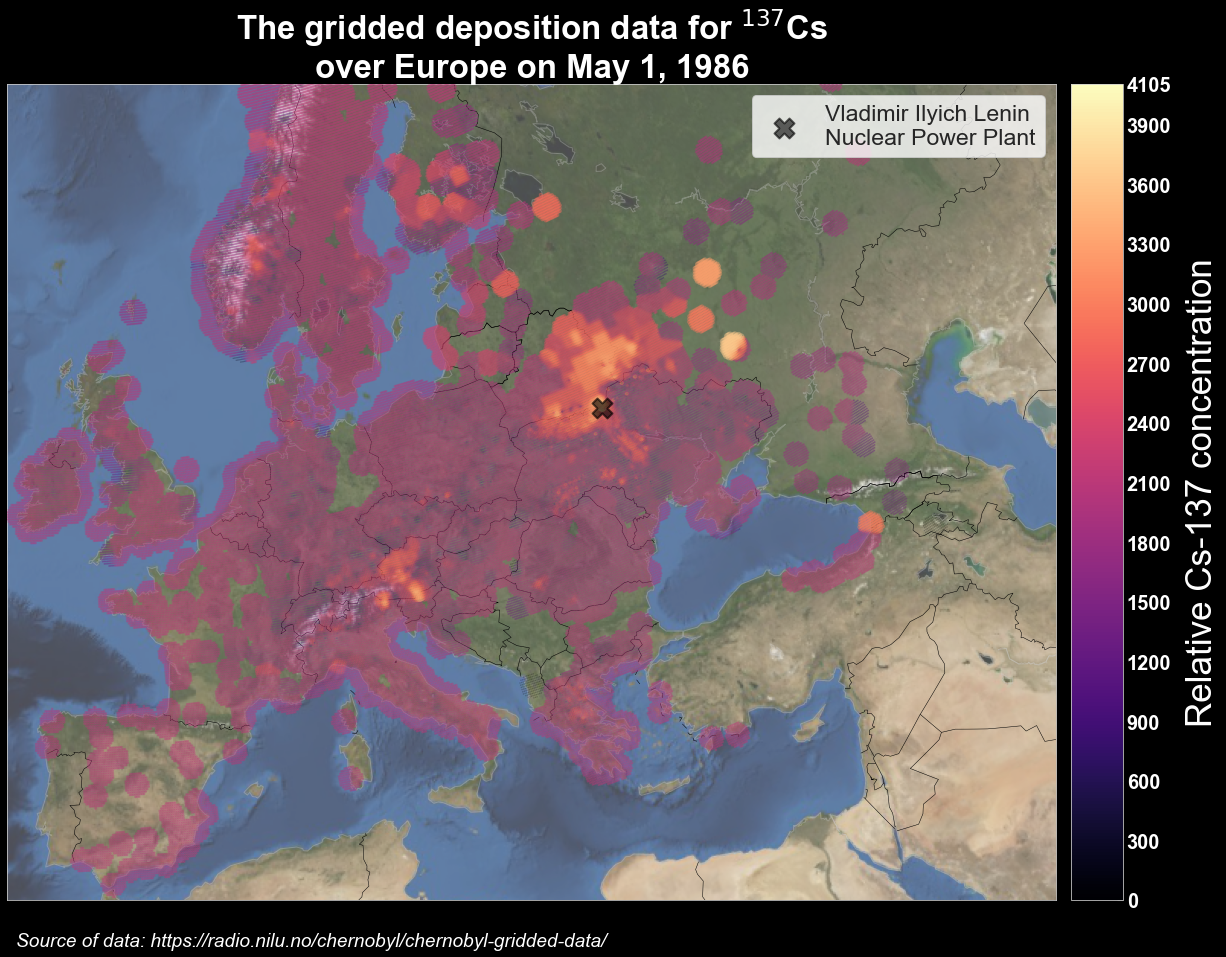

In [296]:
fig, axes = plt.subplots(figsize=(20,20),
                         facecolor='black')

m = Basemap(projection='lcc', resolution='l',
            llcrnrlon=lons[0], llcrnrlat=lats[0], urcrnrlon=lons[-1], urcrnrlat=lats[-200],
            lat_0=lats[0], lon_0=lons[0])
m.bluemarble(axes, scale=1.0, alpha=0.7)

cmap = cm.magma
m.scatter(X, Y, latlon=True,
          c=np.log10(Z), s=np.sqrt(Z),
          cmap=cmap, alpha=0.3, zorder=3)
m.scatter(CH[1], CH[0], latlon=True, label='Vladimir Ilyich Lenin\nNuclear Power Plant',
          color='black', marker='X', s=20**2, 
          alpha=0.6, zorder=4, lw=2)

m.drawcoastlines(color=np.array((0.827,0.827,0.827,0.3)), ax=axes)
m.drawcountries(color=np.array((0.0,0.0,0.0,1.0)), ax=axes)

axes.set_title('The gridded deposition data for $^{137}$Cs\nover Europe on May 1, 1986',
               color='white', fontsize=axistitlesize+7, fontweight='bold')

axes.legend(loc='upper right',
            fontsize=axislegendsize)

# "Source text" position
text_x = 0.29
text_y = -0.05
# Source text
axes.text(x=text_x, y=text_y, s='Source of data: https://radio.nilu.no/chernobyl/chernobyl-gridded-data/',
          c='white', fontsize=axistextsize, fontweight='book', fontstyle='italic',
          horizontalalignment='center', verticalalignment='center', transform=axes.transAxes,
          bbox=dict(facecolor='black', alpha=0.2, lw=0))

# Thank you Stackoverflow
# https://stackoverflow.com/questions/43805821/matplotlib-add-colorbar-to-non-mappable-object
# https://stackoverflow.com/questions/15908371/matplotlib-colorbars-and-its-text-labels
# https://stackoverflow.com/questions/16702479/matplotlib-colorbar-placement-and-size
# https://stackoverflow.com/questions/33443334/how-to-decrease-colorbar-width-in-matplotlib
# https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
norm = mpl.colors.Normalize(vmin=int(np.min(Z)), vmax=int(np.max(Z))+1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
minZ = int(np.min(Z))
maxZ = int(np.max(Z))+1
cbar_ticks = np.append(np.arange(minZ, maxZ, 300), [maxZ])

divider = make_axes_locatable(axes)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(sm, ticks=cbar_ticks,
                    boundaries=np.arange(minZ, maxZ+1, 1),
                    cax=cax)
cbar.set_label('Relative Cs-137 concentration',
               color='white', fontsize=axiscbarfontsize+20, labelpad=15, rotation=90)
cbar.ax.set_yticklabels(['{:.0f}'.format(x) for x in cbar_ticks],
                        color='white', fontsize=axiscbarfontsize+5, weight='bold')

plt.savefig('chernobyl.png',
            format='png',
            dpi=150,
            facecolor='black',
            pad_inches=0.25,
            bbox_inches='tight')

plt.show()